<a href="https://colab.research.google.com/github/phanikumarinampudi/apssdc_ece/blob/master/projectai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
from tensorflow import keras
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [13]:
def read_text(filename):
    file=open(filename, mode='rt', encoding='utf-8')
    text=file.read()
    file.close()
    return text

In [14]:
def to_lines(text):
    sents=text.strip().split('\n')
    sents=[i.split('\t') for i in sents]
    return sents

In [15]:
data=read_text("/deu.txt")
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [16]:
deu_eng = deu_eng[:50000,:]

In [17]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Who else is in there?', 'Wer ist noch dort drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['Who else was in here?', 'Wer war sonst noch hier drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['Who fixed the window?', 'Wer hat das Fenster hergerichtet?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

In [18]:
eng_1=[]
deu_1=[]
for i in deu_eng[:,0]:
    eng_1.append(len(i.split()))
for i in deu_eng[:,1]:
    deu_1.append(len(i.split()))

In [19]:
length_df=pd.DataFrame({'eng':eng_1,'deu':deu_1})

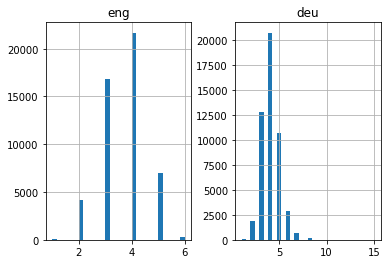

In [20]:
length_df.hist(bins=30)
plt.show()

In [21]:
def tokenization(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [22]:
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
print('English Vocabulary size:%d'%eng_vocab_size)

English Vocabulary size:6167


In [23]:
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('Deutch Vocabulary size:%d'%deu_vocab_size)

Deutch Vocabulary size:10146


In [24]:
def encode_sequences(tokenizer,length,lines):
    seq=tokenizer.texts_to_sequences(lines)
    seq=pad_sequences(seq,maxlen=length,padding='post')
    return seq

In [25]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)

In [26]:
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [27]:
testX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [28]:
def build_model(in_vocab,out_vocab,in_timesteps,out_timesteps,units):
    model=Sequential()
    model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dense(out_vocab,activation='softmax'))
    return model

In [29]:
model=build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)
rms=keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
filename='model.h1.24_aashutosh'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),epochs=5,batch_size=512,validation_split=0.2,callbacks=[checkpoint],verbose=1)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 3.3450
Epoch 00001: val_loss improved from inf to 2.79480, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


63/63 [==============================] - 295s 5s/step - loss: 3.3450 - val_loss: 2.7948
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 2.7006
Epoch 00002: val_loss improved from 2.79480 to 2.68809, saving model to model.h1.24_aashutosh


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


INFO:tensorflow:Assets written to: model.h1.24_aashutosh/assets


63/63 [==============================] - 283s 5s/step - loss: 2.7006 - val_loss: 2.6881
Epoch 3/5
50/63 [======================>.......] - ETA: 50s - loss: 2.5441

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model=load_model('model.h1.24_aashutosh')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==n:
            return word
    return None

In [ ]:
preds_text=[]
for i in preds:
    temp=[]
    for j in range(len(i)):
        t=get_word(i[j],eng_tokenizer)
        if j>0:
            if(t==get_word(i[j-1],eng_tokenizer))or(t==None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t==None):
                temp.append('')
            else:
                temp.append(t)
        preds_text.append(''.join(temp))